Running on: mps
Step 1000, Loss: 0.0303
Ep 1, Score: -20.00, Exploration: 0.995, Steps: 1000
Ep 2, Score: -20.00, Exploration: 0.990, Steps: 1921
Step 2000, Loss: 0.0008
Ep 3, Score: -16.00, Exploration: 0.985, Steps: 2921
Step 3000, Loss: 0.0006
Ep 4, Score: -20.00, Exploration: 0.980, Steps: 3879
Step 4000, Loss: 0.0306
Ep 5, Score: -21.00, Exploration: 0.975, Steps: 4846
Step 5000, Loss: 0.0297
Ep 6, Score: -20.00, Exploration: 0.970, Steps: 5789
Step 6000, Loss: 0.0303
Ep 7, Score: -21.00, Exploration: 0.966, Steps: 6636
Step 7000, Loss: 0.0001
Ep 8, Score: -20.00, Exploration: 0.961, Steps: 7501
Step 8000, Loss: 0.0305
Ep 9, Score: -21.00, Exploration: 0.956, Steps: 8381
Step 9000, Loss: 0.0302
Ep 10, Score: -20.00, Exploration: 0.951, Steps: 9340
Step 10000, Loss: 0.0304
Ep 11, Score: -18.00, Exploration: 0.946, Steps: 10340
Step 11000, Loss: 0.0006
Ep 12, Score: -21.00, Exploration: 0.942, Steps: 11277
Step 12000, Loss: 0.0009
Ep 13, Score: -20.00, Exploration: 0.937, Steps: 121

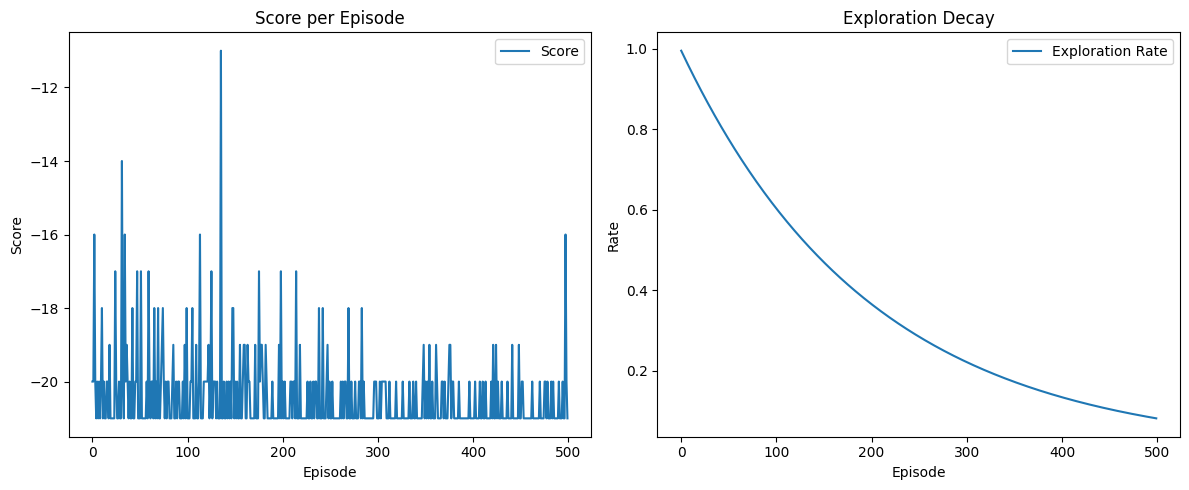

Agent saved as 'pong_agent.pth'
Loaded agent for evaluation


/Users/kumarsatyam/python/reinforcement/assignment2/assignment_2_part_1/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/kumarsatyam/python/reinforcement/assignment2/assignment_2_part_1/pong_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Evaluation episode score: -21.00
Evaluation episode score: -21.00
Evaluation episode score: -21.00
Evaluation episode score: -21.00
Evaluation episode score: -21.00
Average evaluation score over 5 episodes: -21.00
Videos saved in 'pong_videos' directory


In [7]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
from ale_py import ALEInterface
from gymnasium.wrappers import AtariPreprocessing, RecordVideo
import matplotlib.pyplot as plt


class FrameStacker(gym.Wrapper):
    def __init__(self, environment, stack_size):
        super().__init__(environment)
        self.stack_size = stack_size
        self.frame_buffer = deque(maxlen=stack_size)
        base_space = environment.observation_space
        self.observation_space = gym.spaces.Box(
            low=base_space.low.min(),
            high=base_space.high.max(),
            shape=(stack_size,) + base_space.shape,
            dtype=base_space.dtype
        )
    
    def reset(self, **kwargs):
        observation, info = self.env.reset(**kwargs)
        for _ in range(self.stack_size):
            self.frame_buffer.append(observation)
        return self._stacked_frames(), info
    
    def step(self, action):
        observation, reward, term, trunc, info = self.env.step(action)
        self.frame_buffer.append(observation)
        return self._stacked_frames(), reward, term, trunc, info
    
    def _stacked_frames(self):
        return np.stack(self.frame_buffer, axis=0)


class ConvQNet(nn.Module):
    def __init__(self, action_count):
        super(ConvQNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv_layer2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv_layer3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.dense1 = nn.Linear(3136, 512)
        self.output_layer = nn.Linear(512, action_count)
    
    def forward(self, input_tensor):
        x = F.relu(self.conv_layer1(input_tensor))
        x = F.relu(self.conv_layer2(x))
        x = F.relu(self.conv_layer3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.dense1(x))
        return self.output_layer(x)


class ExperienceMemory:
    def __init__(self, max_size):
        self.memory = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, is_done):
        self.memory.append((state, action, reward, next_state, is_done))
    
    def sample_batch(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones))
    
    def size(self):
        return len(self.memory)

# DQN Learning Agent with Double DQN improvement
class PongAgent:
    def __init__(self, action_space_size, computing_device):
        self.device = computing_device
        self.action_space_size = action_space_size
        self.discount_factor = 0.99
        self.exploration_rate = 1.0
        self.min_exploration = 0.01
        self.exploration_decay = 0.995
        self.q_network = ConvQNet(action_space_size).to(computing_device)
        self.target_network = ConvQNet(action_space_size).to(computing_device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.00025)
        self.experience = ExperienceMemory(100000)
        self.batch_size = 32
    
    def choose_action(self, current_state):
        if random.random() < self.exploration_rate:
            return random.randrange(self.action_space_size)
        state_tensor = torch.FloatTensor(current_state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action_values = self.q_network(state_tensor)
            return action_values.argmax().item()
    
    def decay_exploration(self):
        self.exploration_rate = max(self.min_exploration, self.exploration_rate * self.exploration_decay)
    
    def learn(self):
        if self.experience.size() < self.batch_size * 2: 
            return None
        states, actions, rewards, next_states, dones = self.experience.sample_batch(self.batch_size)
        
        states_tensor = torch.FloatTensor(states).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        actions_tensor = torch.LongTensor(actions).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).to(self.device)
        dones_tensor = torch.FloatTensor(dones).to(self.device)
        
        # Double DQN: Use policy net to select actions, target net to evaluate them
        current_q = self.q_network(states_tensor).gather(1, actions_tensor.unsqueeze(1))
        next_actions = self.q_network(next_states_tensor).argmax(1).unsqueeze(1)
        next_q = self.target_network(next_states_tensor).gather(1, next_actions).detach().squeeze()
        target_q = rewards_tensor + (1 - dones_tensor) * self.discount_factor * next_q
        
        loss = F.mse_loss(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        return loss.item()
    
    def sync_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Training and evaluation function
def run_pong_training():
    # Environment setup
    game_env = gym.make("ALE/Pong-v5", render_mode="rgb_array", frameskip=1)
    game_env = AtariPreprocessing(game_env, scale_obs=True)
    game_env = FrameStacker(game_env, stack_size=4)
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Running on: {device}")
    
    # Agent initialization
    action_count = game_env.action_space.n
    pong_agent = PongAgent(action_count, device)
    
    # Training settings
    total_episodes = 500
    target_sync_freq = 1000
    max_total_steps = 1000000
    max_episode_steps = 1000
    
    # Progress tracking
    step_tracker = 0
    exploration_log = []
    performance_log = []
    
    # Training process
    for ep in range(total_episodes):
        current_state, _ = game_env.reset()
        episode_done = False
        episode_score = 0
        steps_in_episode = 0
        
        while not episode_done and steps_in_episode < max_episode_steps and step_tracker < max_total_steps:
            action = pong_agent.choose_action(current_state)
            next_state, reward, term, trunc, _ = game_env.step(action)
            episode_done = term or trunc
            pong_agent.experience.add(current_state, action, reward, next_state, episode_done)
            current_state = next_state
            episode_score += reward
            step_tracker += 1
            steps_in_episode += 1
            
            if pong_agent.experience.size() > pong_agent.batch_size * 2:
                loss = pong_agent.learn()
                if loss is not None and step_tracker % 1000 == 0:
                    print(f"Step {step_tracker}, Loss: {loss:.4f}")
            
            if step_tracker % target_sync_freq == 0:
                pong_agent.sync_target()
        
        pong_agent.decay_exploration()
        performance_log.append(episode_score)
        exploration_log.append(pong_agent.exploration_rate)
        print(f"Ep {ep + 1}, Score: {episode_score:.2f}, Exploration: {pong_agent.exploration_rate:.3f}, Steps: {step_tracker}")
    
    game_env.close()
    
    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(performance_log, label='Score')
    plt.title('Score per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(exploration_log, label='Exploration Rate')
    plt.title('Exploration Decay')
    plt.xlabel('Episode')
    plt.ylabel('Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Model persistence
    torch.save(pong_agent.q_network.state_dict(), 'pong_agent.pth')
    print("Agent saved as 'pong_agent.pth'")
    
    # Evaluation setup
    eval_env = gym.make("ALE/Pong-v5", render_mode="rgb_array", frameskip=1)
    eval_env = AtariPreprocessing(eval_env, scale_obs=True)
    eval_env = FrameStacker(eval_env, stack_size=4)
    eval_env = RecordVideo(eval_env, "pong_videos", episode_trigger=lambda x: True)
    
    # Load and evaluate
    eval_network = ConvQNet(action_count).to(device)
    eval_network.load_state_dict(torch.load('pong_agent.pth'))
    eval_network.eval()
    print("Loaded agent for evaluation")
    
    # Run multiple evaluation episodes for better assessment
    eval_scores = []
    for _ in range(5):  # Evaluate over 5 episodes
        eval_state, _ = eval_env.reset()
        eval_done = False
        eval_score = 0
        while not eval_done:
            state_input = torch.FloatTensor(eval_state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_vals = eval_network(state_input)
                action = q_vals.argmax().item()
            next_state, reward, term, trunc, _ = eval_env.step(action)
            eval_done = term or trunc
            eval_score += reward
            eval_state = next_state
        eval_scores.append(eval_score)
        print(f"Evaluation episode score: {eval_score:.2f}")
    
    eval_env.close()
    avg_score = np.mean(eval_scores)
    print(f"Average evaluation score over 5 episodes: {avg_score:.2f}")
    print("Videos saved in 'pong_videos' directory")

if __name__ == "__main__":
    run_pong_training()